In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None

import nltk
# nltk.download("popular")

# Defining Random state
rs = 42

import tensorflow as tf
import tensorflow_hub as hub

In [3]:
df = pd.read_csv('airline_sentiment.csv')
df.head()

,customer_review,recommended
0,âœ… Trip Verified | London to Izmir via Istanb...,yes
1,âœ… Trip Verified | Istanbul to Bucharest. We ...,no
2,âœ… Trip Verified | Rome to Prishtina via Ista...,no
3,âœ… Trip Verified | Flew on Turkish Airlines I...,yes
4,âœ… Trip Verified | Mumbai to Dublin via Istan...,no


In [4]:
df.shape

(59750, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59750 entries, 0 to 59749
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_review  59750 non-null  object
 1   recommended      59750 non-null  object
dtypes: object(2)
memory usage: 933.7+ KB


In [6]:
# Checking if the data is balanced or imbalanced
df['recommended'].value_counts(1)

no     0.523264
yes    0.476736
Name: recommended, dtype: float64

#### Observe that our dataset is a balanced dataset with 2 classes with similar proportions

# Cleaning reviews to pass into ML/DL models

### Cleaning steps:
    - lowercase
    - whitespaces
    - html tags, unicode char, emoji
    - twitter usernames
    - punctuations and numbers (except ' and - )
    - replace "-" with whitespace
    - acronyms
    - contractions  
    - remove all punctuations again
    - lemmatize
    - Stopwords, additional stopwords
    - keep only alphabets and " "
    - remove words with one alphabet occuring more than 3 times continuously
    - remove words with less than 3 characters 

In [7]:
df['customer_review'].sample(10)

49840    Never again will we fly this airline. The plan...
16406    Ekaterinburg to Moscow with Aeroflot. Economy ...
25064    âœ… Trip Verified | Guangzhou to Moscow via Wu...
52210    BKK-DAC. I ended up having to purchase their f...
43969    We are a family of 5 who had booked a flight f...
4783     âœ… Trip Verified | Chicago to Rome via Munich...
33549    AF1068 CDG to Manchester on Sunday 16 February...
4485     The first class "service" on this Auckland-Mel...
52781    Jogjakarta to Sydney via Bali, and very impres...
3795     I would rate Emirates as a good airline but it...
Name: customer_review, dtype: object

In [5]:
import re
import string
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

# Defining acronyms
acronyms_dict = pd.read_json('acronym.json', typ = 'series')

# Defining contractions
contractions_dict = pd.read_json('contractions.json', typ = 'series')

# Defining stopwords

alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe", "ï", "ûï"]
stops = alphabets + others
stops = list(set(stops))

# Defining tokenizer
regexp = RegexpTokenizer("[\w']+")

# Preprocessing
def preprocess(text):
    
    text = text.lower()                                                                                        # lowercase
    text = text.strip()                                                                                        # whitespaces
    
    # Removing html tags
    html = re.compile(r'<.*?>')
    text = html.sub(r'', text)                                                                                 # html tags
    
    # Removing emoji patterns
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'', text)                                                                         # unicode char
    
    # Removing urls
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    text = re.sub(pattern, "", text)                                                                            # remove urls
    
    # Removing twitter usernames
    pattern = r'@[\w_]+'
    text = re.sub(pattern, "", text)                                                                            # remove @twitter usernames
    
    # Removing punctuations and numbers
    punct_str = string.punctuation + string.digits
    punct_str = punct_str.replace("'", "")
    punct_str = punct_str.replace("-", "")
    text = text.translate(str.maketrans('', '', punct_str))                                                     # punctuation and numbers
    
    # Replacing "-" in text with empty space
    text = text.replace("-", " ")                                                                               # "-"
    
    # Substituting acronyms
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_dict.index:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()
    text = ' '.join(words)                                                                                       # acronyms
    
    # Substituting Contractions
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_dict.index:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    text = " ".join(words)                                                                                       # contractions
    
    punct_str = string.punctuation
    text = text.translate(str.maketrans('', '', punct_str))                                                     # punctuation again to remove "'"
                                                                       
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in regexp.tokenize(text)])                             # lemmatize
    
    # Stopwords Removal
    text = ' '.join([word for word in regexp.tokenize(text) if word not in stops])                              # stopwords
    
    # Removing all characters except alphabets and " " (space)
    filter = string.ascii_letters + " "
    text = "".join([chr for chr in text if chr in filter])                                                      # remove all characters except alphabets and " " (space)
    
    # Removing words with one alphabet occuring more than 3 times continuously
    pattern = r'\b\w*?(.)\1{2,}\w*\b'
    text = re.sub(pattern, "", text).strip()                                                                    # remove words with one alphabet occuring more than 3 times continuously
    
    # return final output
    return text

In [9]:
df['review_clean'] = df['customer_review'].apply(lambda x : preprocess(x))

In [10]:
df[['customer_review', 'review_clean', 'recommended']].sample(10)

,customer_review,review_clean,recommended
7078,JFK to LAX. Airplane was clean and looked good...,jfk to lax airplane wa clean and looked good b...,no
12190,I have been on 6 flights in two days and all f...,have been on flight in two day and all flight ...,yes
54184,âœ… Verified Review | This was my first time f...,verified review this wa my first time flying w...,no
16014,First flight with Aegean Airlines and found it...,first flight with aegean airline and found it ...,yes
18425,âœ… Trip Verified | My wife and I flew SkyCouc...,trip verified my wife and flew skycouch housto...,yes
49922,Round-trip Latrobe to Myrtle Beach to visit fa...,round trip latrobe to myrtle beach to visit fa...,no
52381,flydubai is a low cost although depending on t...,flydubai is low cost although depending on the...,yes
35267,âœ… Trip Verified | Abu Dhabi to Paris return ...,trip verified abu dhabi to paris return via am...,yes
52849,Top notch service by Garuda Indonesia cabin cr...,top notch service by garuda indonesia cabin cr...,yes
26169,Los Angeles to Delhi via Guangzhou and back wi...,los angeles to delhi via guangzhou and back wi...,yes


In [11]:
# Splitting Data into train and test
X = df["review_clean"]
y = df["recommended"].replace({'yes':1, 'no':0})

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

print(f"shape of X_train: {X_train.shape}")
print(f"shape of X_test: {X_test.shape}")
print(f"shape of y_train: {y_train.shape}")
print(f"shape of y_test: {y_test.shape}")

shape of X_train: (47800,)
shape of X_test: (11950,)
shape of y_train: (47800,)
shape of y_test: (11950,)


In [12]:
# Checking Number of unique words in X_train. They will constitute our vocabulary.
vocab = []

for tweet in X_train:
    tweet_words = tweet.split()
    vocab.extend(tweet_words)
    
print(f"Number of unique words in X_train = {len(set(vocab))}")

Number of unique words in X_train = 34065


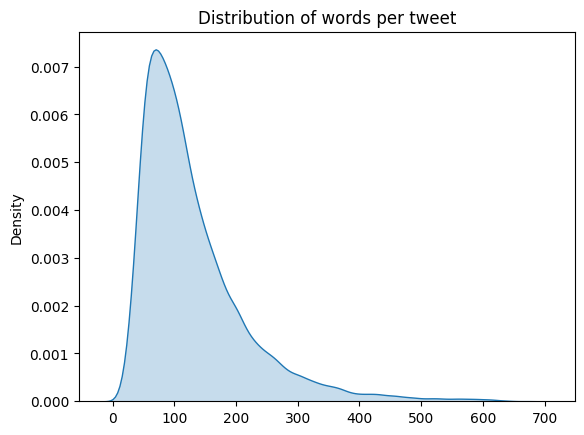

In [13]:
tokens_per_review = [len(tweet.split()) for tweet in X_train]

sns.kdeplot(tokens_per_review, fill=True)
plt.title('Distribution of words per tweet')
plt.show()

In [14]:
pd.Series(tokens_per_review).describe()

count    47800.000000
mean       130.194937
std         87.672131
min         12.000000
25%         70.000000
50%        106.000000
75%        163.000000
max        682.000000
dtype: float64

# Transfer Learning using Universal Sentence Encoder.

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens = None,                             # Number of words in vocabulary
                               standardize = 'lower_and_strip_punctuation',   # How to process text
                               split = 'whitespace',                          # How to split tokens from document
                               ngrams = None,                                 # Define n-grams size if necessary
                               output_mode = 'int',                           # How to map tokens to output
                               output_sequence_length = 200                  # Determines the maximum length of the output sequences
                               )

# fit the vectorizer on training text
vectorizer.adapt(X_train) 

In [16]:
# Creating Embedding Layer using Tensorflow
from tensorflow.keras import layers
max_vocab_length = len(vectorizer.get_vocabulary())
max_length = 200
embedding = layers.Embedding(input_dim= max_vocab_length,                         # set input shape
                             output_dim=128,                                      # set size of embedding vector
                             embeddings_initializer="uniform",                    # default, intialize uniform
                             input_length=max_length,                             # how long is each input
                             name="embedding_1")

embedding

In [17]:
# Loading embeddings from Universal-Senetence-Encoder from tensorflow hub
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [18]:
embed_samples = embed(["hello", "world"])
print(f"shape of embed_samples : {embed_samples.shape}")
embed_samples

shape of embed_samples : (2, 512)


<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.03524597, -0.07763016,  0.02360611, ..., -0.04345534,
        -0.03908164, -0.00791795],
       [-0.07942116, -0.07860354, -0.05497928, ..., -0.08418675,
         0.00950206, -0.07789143]], dtype=float32)>

In [19]:
import tensorflow_hub as hub
from tensorflow.keras import layers
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],              # shape of inputs coming to our model
                                        dtype=tf.string,             # data_type of inputs coming to the USE layer
                                        trainable=False,             # whether the USE layer is trainable or not
                                        name = "USE"
                                       )

# Creating model using Sequential API
# set_seed(12)

model_transfer = tf.keras.Sequential([
    sentence_encoder_layer,                                  # Take in sentences and encode them into an embedding
    layers.Reshape((1, 512)),                                # Reshape the output to (1, 512)
    layers.LSTM(64, return_sequences=True),                  # lstm layer 1
    layers.Dropout(rate = 0.3),
    layers.LSTM(64),                                         # lstm layer 2
    layers.Dense(32, activation = "relu"),                   # Hidden Layer
    layers.Dropout(rate = 0.3),
    layers.Dense(16, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")                  # Output Layer
], name = "model_transfer_USE")

# Compiling the model
model_transfer.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

# Fitting the model
model_transfer_history = model_transfer.fit(X_train, y_train, epochs = 5, batch_size = 50, validation_data = (X_test, y_test))

Epoch 1/5



956/956 [==============================] - 36s 32ms/step - loss: 0.3089 - accuracy: 0.8740 - val_loss: 0.2660 - val_accuracy: 0.8929
Epoch 2/5
956/956 [==============================] - 30s 32ms/step - loss: 0.2681 - accuracy: 0.8928 - val_loss: 0.2619 - val_accuracy: 0.8934
Epoch 3/5
956/956 [==============================] - 30s 31ms/step - loss: 0.2611 - accuracy: 0.8953 - val_loss: 0.2601 - val_accuracy: 0.8937
Epoch 4/5
956/956 [==============================] - 29s 30ms/step - loss: 0.2579 - accuracy: 0.8973 - val_loss: 0.2602 - val_accuracy: 0.8941
Epoch 5/5
956/956 [==============================] - 29s 30ms/step - loss: 0.2558 - accuracy: 0.8974 - val_loss: 0.2600 - val_accuracy: 0.8941


In [20]:
model_transfer.save("nlp_model")

INFO:tensorflow:Assets written to: nlp_model\assets


INFO:tensorflow:Assets written to: nlp_model\assets


In [3]:
load_model = tf.keras.models.load_model("nlp_model")
load_model.summary()



Model: "model_transfer_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 reshape (Reshape)           (None, 1, 512)            0         
                                                                 
 lstm (LSTM)                 (None, 1, 64)             147712    
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)       

In [22]:
# Taking predictions
predictions = load_model.predict(X_test)

374/374 [==============================] - 7s 16ms/step


In [24]:
predictions

array([[0.26693416],
       [0.9433658 ],
       [0.9800874 ],
       ...,
       [0.99983644],
       [0.05822678],
       [0.23450834]], dtype=float32)

In [23]:
# Evaluating Model
load_model.evaluate(X_test, y_test)

374/374 [==============================] - 7s 16ms/step - loss: 0.2600 - accuracy: 0.8941


[0.25998353958129883, 0.8940585851669312]

In [25]:
y_pred = np.where(predictions > 0.5, 1, 0)
y_pred = pd.DataFrame(y_pred, index = y_test.index, columns = ["Predicted"])
y_pred

,Predicted
34047,0
16730,1
16382,1
31536,0
10476,0
...,...
37936,1
59216,0
15506,1
49865,0


In [26]:
test_pred_df = pd.concat([X_test, y_test, y_pred], axis = 1)
test_pred_df

,review_clean,recommended,Predicted
34047,verified review dallas to abu dhabi disappoint...,0,0
16730,trip verified mexico city to puerto vallarta w...,1,1
16382,travelled aeroflot russian airline from new yo...,1,1
31536,trip verified brisbane to tokyo via sydney her...,0,0
10476,verified review one of the worst experience ev...,0,0
...,...,...,...
37936,verified review flew lisbon to helsinki great ...,1,1
59216,verified review keflavik to dublin this is the...,0,0
15506,first time flying with them and loved every mi...,1,1
49865,any money you save is negated by carry on bag ...,0,0


In [27]:
test_pred_df[(test_pred_df['recommended'] == 1) & (test_pred_df["Predicted"] == 0)]

,review_clean,recommended,Predicted
33318,june af athens paris seat wa bit narrow and co...,1,0
58046,had been reading norwegian review here since b...,1,0
37540,outbound from heathrow wa good food wa served ...,1,0
34403,the flight from bangalore to abu dhabi wa smoo...,1,0
50555,verified review flew mahon to barcelona boardi...,1,0
...,...,...,...
2705,flew for the first time with qatar cdg doh mle...,1,0
27933,minute domestic flight hel vaa operated by nor...,1,0
6427,lagos to new york via amsterdam the connecting...,1,0
11789,baltimore to wichita with southwest airline pu...,1,0


In [30]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      6240
           1       0.88      0.90      0.89      5710

    accuracy                           0.89     11950
   macro avg       0.89      0.89      0.89     11950
weighted avg       0.89      0.89      0.89     11950



In [33]:
# Taking Predictions on Random Reviews

review = '''
    Such a horrible flight experience. The staff was rude and seats were uncomfortable. Do not recommend
'''
clean_review = preprocess(review)
print(f'Clean_tweet ====> "{clean_review}"')
load_model.predict([clean_review])

Clean_tweet ====> "such horrible flight experience the staff wa rude and seat we are uncomfortable do not recommend"
1/1 [==============================] - 0s 35ms/step


array([[0.00411902]], dtype=float32)

In [7]:
# Taking Predictions on Random Reviews

review = '''
    Excellent flight experience. Polite crew. Definitely commend
'''
clean_review = preprocess(review)
print(f'Clean_tweet ====> "{clean_review}"')
load_model.predict([clean_review])

Clean_tweet ====> "excellent flight experience polite crew definitely commend"
1/1 [==============================] - 0s 39ms/step


array([[0.98793495]], dtype=float32)